In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Find Keypoint and match between 2 images

In [2]:
def detect_and_match_keypoint(image_1,image_2):
    # image_1 = query image
    # image_2 = train image
    # Initiate SIFT detector
    sift = cv2.SIFT()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image_1,None)
    kp2, des2 = sift.detectAndCompute(image_2,None)
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    # Apply ratio test
    match_details = []
    image_1_keypoint = []
    image_2_keypoint = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            match_details.append([m])
            image_1_keypoint.append(kp1[m.queryIdx])
            image_2_keypoint.append(kp2[m.trainIdx])
    # cv2.drawMatchesKnn expects list of lists as matches.
#     matched_image = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,flags=2)
    return match_details,image_1_keypoint,image_2_keypoint

In [3]:
def draw_match_keypoint(image_1_keypoint,image_2_keypoint,image_1,image_2):
    image_1_rows,image_1_cols = image_1.shape
    image_2_rows,image_2_cols = image_2.shape
    match_image_rows = image_1_rows if image_1_rows > image_2_rows else image_2_rows
    match_image_cols = image_1_cols + image_2_cols
    print match_image_rows
    print match_image_cols
    match_image = np.zeros((match_image_rows, match_image_cols))
    match_image[0:image_1_rows,0:image_1_cols] = image_1
    match_image[0:image_2_rows,image_1_cols:] = image_2
    for i in range(0,len(image_1_keypoint)):
        ptA = (int(image_1_keypoint[i][0]), int(image_1_keypoint[i][1]))
        ptB = (int(image_2_keypoint[i][0]) + image_1_cols, int(image_2_keypoint[i][1]))
        cv2.line(match_image, ptA, ptB,255, 1)
    return match_image

### Read image and find its keypoint

In [4]:
image_1 = cv2.imread('bryce_left_01.png',0)
image_2 = cv2.imread('bryce_right_01.png',0) # trainImage
match_details,image_1_keypoint,image_2_keypoint = detect_and_match_keypoint(image_1,image_2)

### Convert keypoint object to 2d numpy array of position of each keypoint
#### keypoint at same index refer to same position in world

In [5]:
#convert keypoint object to 2d array
image_1_keypoint = np.float32([kp.pt for kp in image_1_keypoint])
image_2_keypoint = np.float32([kp.pt for kp in image_2_keypoint])

#### draw matching keypoint

750
2000


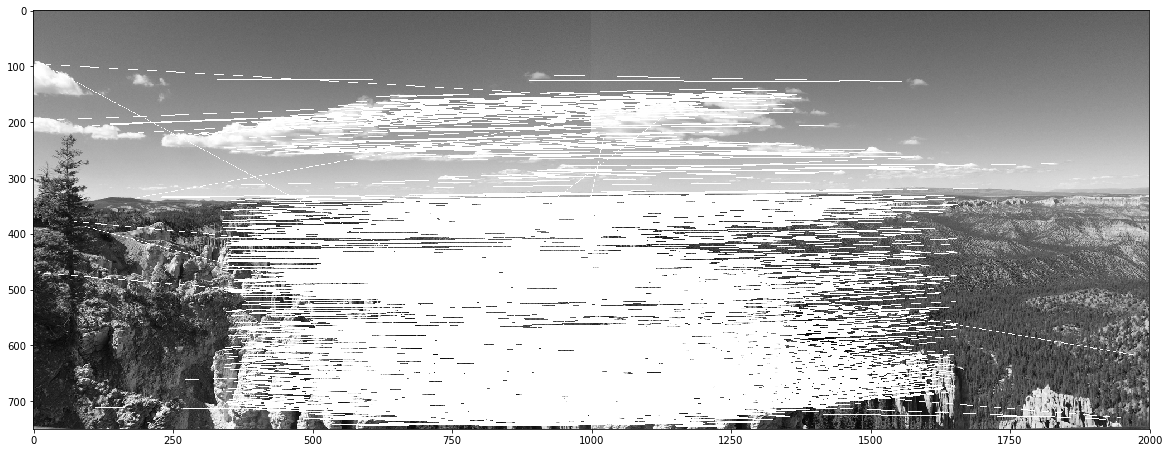

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(draw_match_keypoint(image_1_keypoint,image_2_keypoint,image_1,image_2),cmap='gray')
plt.show()

# Use RANSAC to find transform matrix 

In [18]:
h, status = cv2.findHomography(image_1_keypoint, image_2_keypoint)
h

array([[  8.87259434e-01,  -7.72302407e-02,  -2.14468518e+02],
       [ -7.58626555e-02,   8.51236540e-01,   6.87112877e+01],
       [  1.72062176e-06,  -1.57665024e-04,   1.00000000e+00]])

#### transform coordinate image

In [19]:
result = cv2.warpPerspective(image_1, h,(image_1.shape[1] + image_2.shape[1], image_1.shape[0]))
result[0:image_2.shape[0], 0:image_2.shape[1]] = image_2

#### draw output or panorama image

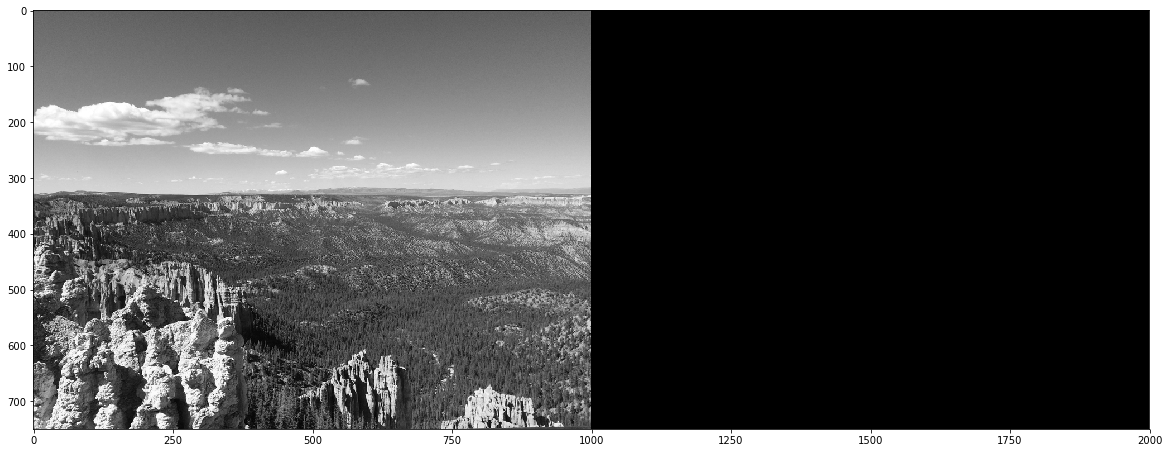

In [20]:
plt.figure(figsize=(20,20))
plt.imshow(result,cmap='gray')
plt.show()